# Week 7 - Temporal models 

## Part 0: Introduction to NumPyro

In this part, we will be introducing NumPyro: a lightweight probabilistic programming library that provides a NumPy backend for Pyro (opposed to the classical Pytorch backend as in "pure" Pyro). The reason being this is that for complex small-scale problem (such as the Temporal Models we will be implementing today) Pyro ends up being slowed down substantially because of the Pytorch backend. 

In practice, as we will see in this Notebook, the changes will be minimal (most of the times, it will simply mean using `numpyro`.X instead of the usual `pyro`.X), but the advantages in terms of computation time will be substantial :)

(we obviously highly advise checking the official material on the numpyro channels: [Github](https://github.com/pyro-ppl/numpyro), [Documentation](http://num.pyro.ai/en/stable/#), [Examples](https://pyro.ai/numpyro/index.html))


**Disclaimer: we are not saying that numpyro is more efficient than Pyro in all settings. However, for specific problems, doing MCMC sampling can be very expensive in Pyro and for this reason adding numpyro to our bag of tools becomes very important** 


Notice the new imports...

In [1]:
# Install Pyro + NumPyro, if necessary
!pip install pyro-ppl
!pip install "jax[cpu]===0.3.14" -f https://whls.blob.core.windows.net/unstable/index.html --use-deprecated legacy-resolver
!pip install numpyro

Looking in links: https://whls.blob.core.windows.net/unstable/index.html
     -------------------------------------- 990.1/990.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 124.4/124.4 kB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 44.3/44.3 MB 1.5 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.3.14-py3-none-any.whl size=1147576 sha256=bc2091c1911520da4061f051e8a807e683a73df84384b83bec3d65c1933def1d
  Stored in directory: c:\users\jakob\appdata\local\pip\cache\wheels\d4\db\00\c0fba1bd7cf4b5c31181c9a7db4081d79626835477418790fb
Successfully built jax
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.4
    Uninstalling flatbuffers-23.1.4:
      Successfully uninstalled flatbuffers-23.1.4
  Using cached numpyro-0.11.0-py3-none-any.whl (300 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl 

Before getting into the core of the Lecture (the temporal models), the next section is aimed at giving some concrete feel of the computational advantages NumPyro will bring us when modeling. 

Concretely, section 7.1 will run you through the Linear Regression excercise from Lecture 5. Here however, we will be implementing two versions of the same model, the first will be Pyro based (exactly as we did it in Lecture 5) and the second will be translating the model in NumPyro syntax. The motivation here is two-fold: 
- compare the running times of the two implementations
- show in a simple example how straight-forward it can be to switch from Pyro to NumPyro and vice-versa :)

In this Notebook the code has been entirely written for you, but be sure to understand what each component is doing. Let's start!

## 7.1 NumPyro Motivation - Bayesian Linear Regression Comparison

In [2]:
# General imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

c:\Users\jakob\anaconda3\envs\my_environment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To start let's load the data and implement the pre-processing exactly as in Lecture 5. The problem will again be the modelling of taxi pickups in Wall Street.

(no need to invest time here, take it as if the data had been given to us already processed)

In [3]:
# load csv (original dataset is by 30min intervals, we want 1h intervals) into a Pandas Dataframe
df = pd.read_csv("http://mlsm.man.dtu.dk/mbml/pickups+weather_wallstreet.csv")

# look at the first few lines of the loaded dataset
df.head()

# convert datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d")

# filter: use only data from 2015
df = df[df.datetime.dt.year == 2015]

# add column with day of week (dow) and time of day (tod)
df["dow"] = df["datetime"].dt.weekday
df["tod"] = df["datetime"].dt.hour

enc=np.array(pd.get_dummies(df["tod"]))
# prepare matrix with time features
X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)

# prepare matrix with weather features
X_weather = df[["min_temp","max_temp","wind_speed","wind_gust",
                "visibility","pressure","precipitation","snow_depth",
                "fog","rain_drizzle","snow_ice"]].values
X_weather = df[["min_temp","snow_depth","precipitation"]].values

# create matrix with time and weather features
X = np.concatenate([X_time, X_weather], axis=1)

# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std
# prepare vector of target taxi pickups
y = df["pickups"].values

# standardize pickups
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_time_train = X_time[ix_train,:]
X_time_test = X_time[ix_test,:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

As usual, it is always a good idea to start by visualizing our data

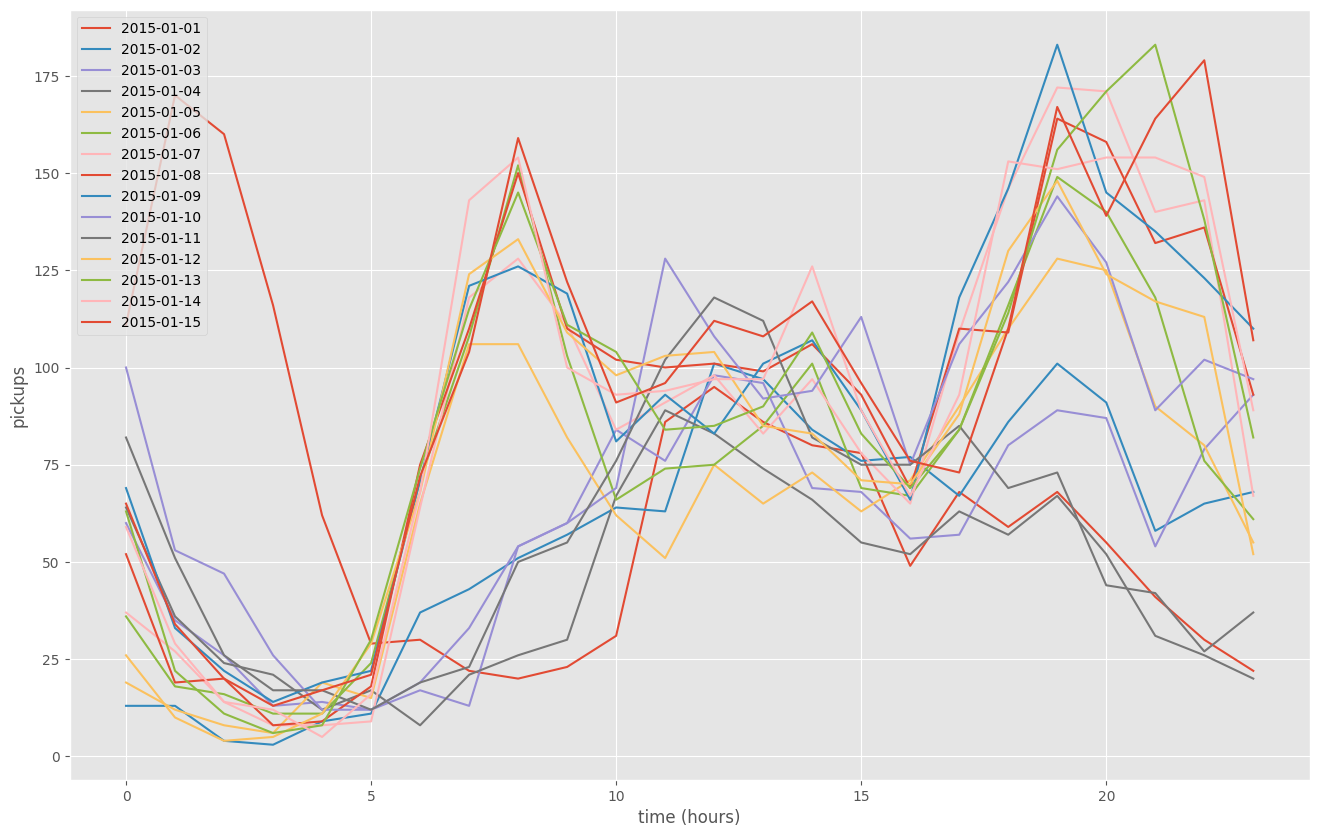

In [6]:
# visualize first 15 days of January 2015
dates = []
for day in range(1,16):   # we will search for days 1-15
    date = "2015-01-%.2d" % (day,)
    dates.append(date)
    plt.plot(df[df.date == date]["pickups"].values)   # select lines with corresponding date
plt.xlabel("time (hours)")
plt.ylabel("pickups")
plt.legend(dates);

and again, as in Lecture 5, let's implement a function to check our models' performance...

In [7]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

### 7.1.1 Pyro

We start by implementing the Pyro version of the Linear Regression model.

The following should all make sense to you :)

In [8]:
# Pyro-specific imports
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

In [9]:
# Model definition
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])))    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [10]:
# Prepare data for Pyro model (notice the torch.tensor)
X_train_small = torch.tensor(X_train[:1000,:]).float()
y_train_small = torch.tensor(y_train[:1000]).float()

In [11]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [05:21,  3.74it/s, step size=3.20e-02, acc. prob=0.849]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.04      0.02     -0.04     -0.07     -0.01    205.31      1.00
   beta[0]      0.01      0.39      0.02     -0.55      0.65     85.37      1.01
   beta[1]      0.08      0.39      0.10     -0.49      0.72     84.88      1.01
   beta[2]      0.13      0.39      0.15     -0.45      0.77     84.29      1.01
   beta[3]      0.11      0.39      0.12     -0.46      0.76     85.09      1.01
   beta[4]      0.12      0.39      0.14     -0.46      0.75     85.07      1.01
   beta[5]      0.09      0.39      0.10     -0.48      0.73     85.31      1.01
   beta[6]     -0.17      0.39     -0.15     -0.75      0.46     84.75      1.01
   beta[7]     -0.11      0.18     -0.11     -0.43      0.17     66.96      1.03
   beta[8]     -0.22      0.18     -0.22     -0.54      0.05     67.21      1.03
   beta[9]     -0.32      0.18     -0.32     -0.65     -0.05     68.21      1.03
  beta[10]     -0.35      0

The pyro implementation should have run in something between 3 and 4 minutes time. As usual let's look at the posterior distributions over the parameters and evaluate the performance of our model:

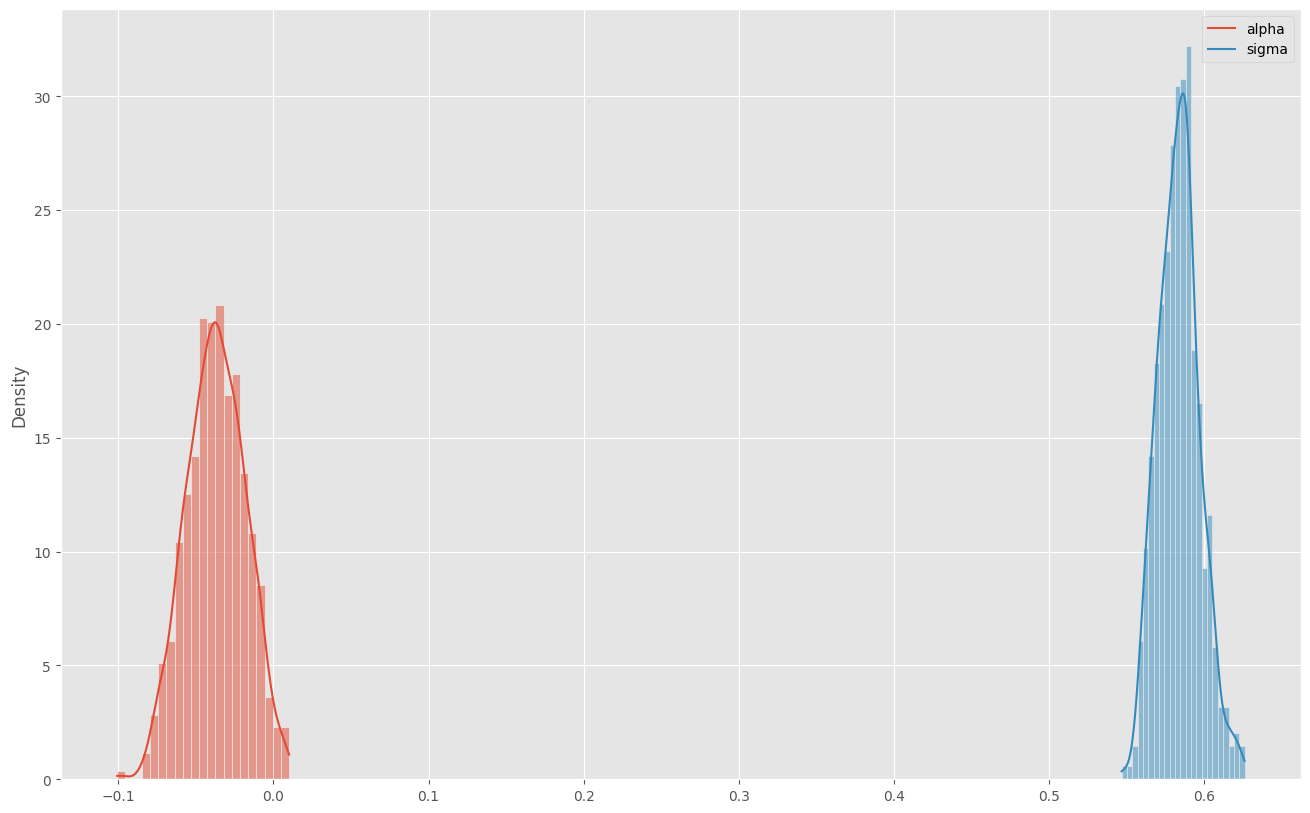

In [16]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.histplot(posterior_samples["alpha"], kde=True, stat="density")
sns.histplot(posterior_samples["sigma"], kde=True, stat="density")
plt.legend(["alpha", "sigma"])
plt.show()

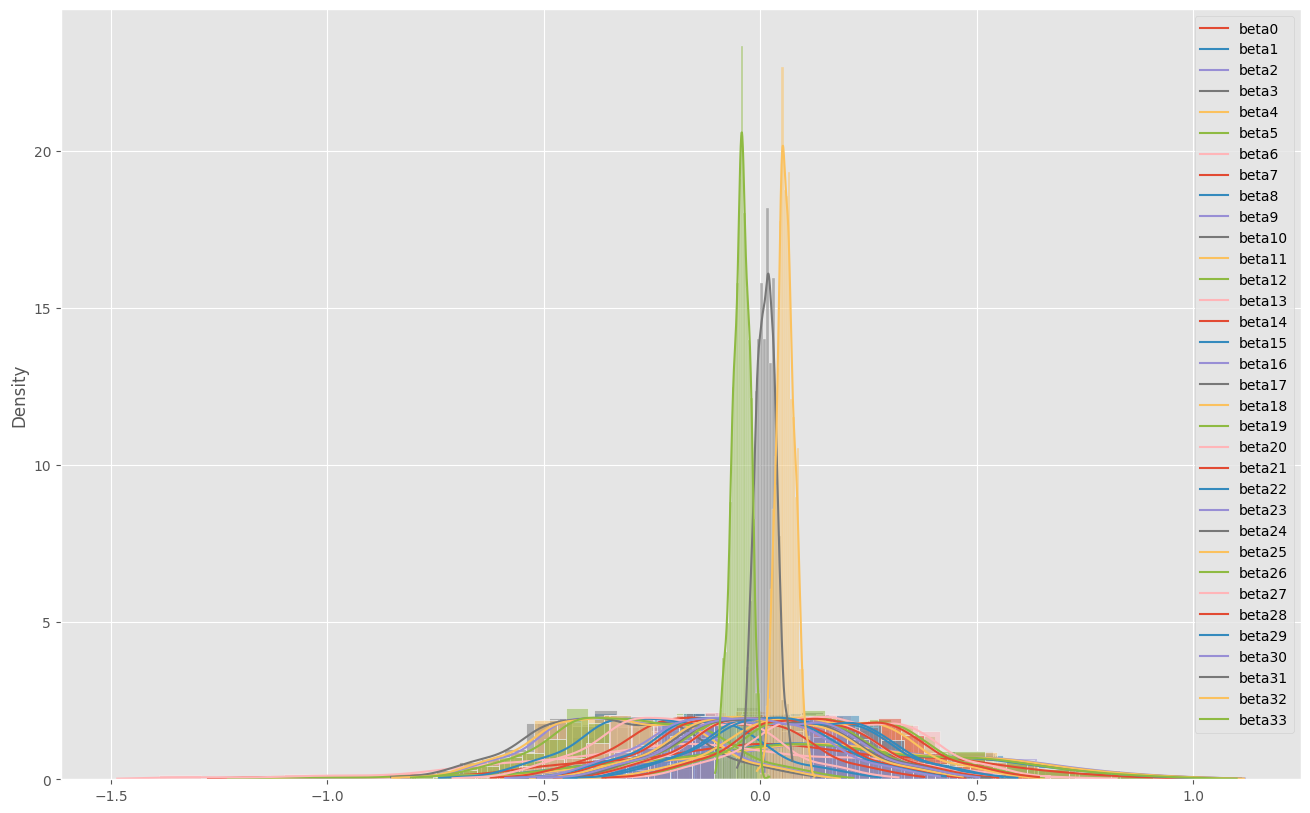

In [19]:
for i in range(X.shape[1]):
    sns.histplot(posterior_samples["beta"][:,i], kde=True, stat="density")
plt.legend(["beta%d" % i for i in range(X.shape[1])])
plt.show()

Now, lets extract the posterior samples from Pyro and make predictions for the test set

In [20]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)

And lets check the error statistics...

In [21]:
# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.794
MAE: 19.730
RMSE: 26.555
R2: 0.626


### 7.1.2 NumPyro

Here is where NumPyro finally comes into play. To start off, the "new" imports...

In [22]:
# NumPyro-specific imports
import numpyro
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS

Below you can see the NumPyro version of our Linear Regression model. As it is quite evident, the changes are really minimal. In this example, the changes regard:
- using `numpyro` instead of `pyro`
- explicitly declaring the length of the plate
- using `jax.numpy` (i.e. `jnp` in the code) instead of `torch` (this because, as explained earlier, NumPyro uses Numpy as backed opposed to Pytorch...)

In [23]:
def model(X, obs=None):
    alpha = numpyro.sample("alpha", numpyro.distributions.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = numpyro.sample("beta", numpyro.distributions.Normal(jnp.zeros(X.shape[1]), 
                                            jnp.ones(X.shape[1])))                          # Priors for the regression coeffcients
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfCauchy(5.))                   # Prior for the variance
    
    with numpyro.plate("data", X.shape[0]):
        y = numpyro.sample("y", numpyro.distributions.Normal(alpha + jnp.matmul(X, beta), sigma), obs=obs)
        
    return y

In [24]:
# Prepare data for NumPyro model (notice the np.array instead of torch.tensor)
X_train_small = X_train[:1000,:]
y_train_small = y_train[:1000]

We are now ready to run inference in NumPyro (again, notice the slight differences). 

Here the major difference is the need of a "PRNGKey" to instantiate the sampling procedure. For the great majority of use-cases this is all that there is to it: the NumPyro sampler requires an explicit Random Number Generator Key (i.e. a PRNGKey).

In [25]:
# Run inference in NumPyro

# Define key
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=200, num_chains=1)
mcmc.run(rng_key_, X_train_small, y_train_small)

# Show summary of inference results
mcmc.print_summary()

sample: 100%|██████████| 1200/1200 [00:09<00:00, 122.23it/s, 63 steps of size 7.79e-02. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.04      0.02     -0.04     -0.07     -0.01    467.22      1.00
   beta[0]     -0.08      0.41     -0.08     -0.80      0.48    118.14      1.00
   beta[1]     -0.00      0.40     -0.01     -0.72      0.56    118.36      1.00
   beta[2]      0.05      0.40      0.04     -0.66      0.63    118.13      1.00
   beta[3]      0.03      0.41      0.01     -0.67      0.61    118.39      1.00
   beta[4]      0.04      0.41      0.03     -0.69      0.59    119.05      1.00
   beta[5]      0.00      0.40     -0.01     -0.68      0.59    118.14      1.00
   beta[6]     -0.25      0.40     -0.26     -0.98      0.29    118.73      1.00
   beta[7]     -0.02      0.18     -0.02     -0.30      0.24     31.37      1.03
   beta[8]     -0.13      0.18     -0.13     -0.42      0.13     31.29      1.03
   beta[9]     -0.23      0.18     -0.23     -0.50      0.04     31.38      1.03
  beta[10]     -0.26      0

If everything worked correctly, you should have observed a quite striking difference in computing performance (in our run, 10sec vs 3:40mins). Imagine this difference growing exponentially for more complex problems... (this happens especially in temporal models). Let's now check that the results were equally good:

Plot the posterior distribution of all the latent variables in the model (alpha, betas and sigma).

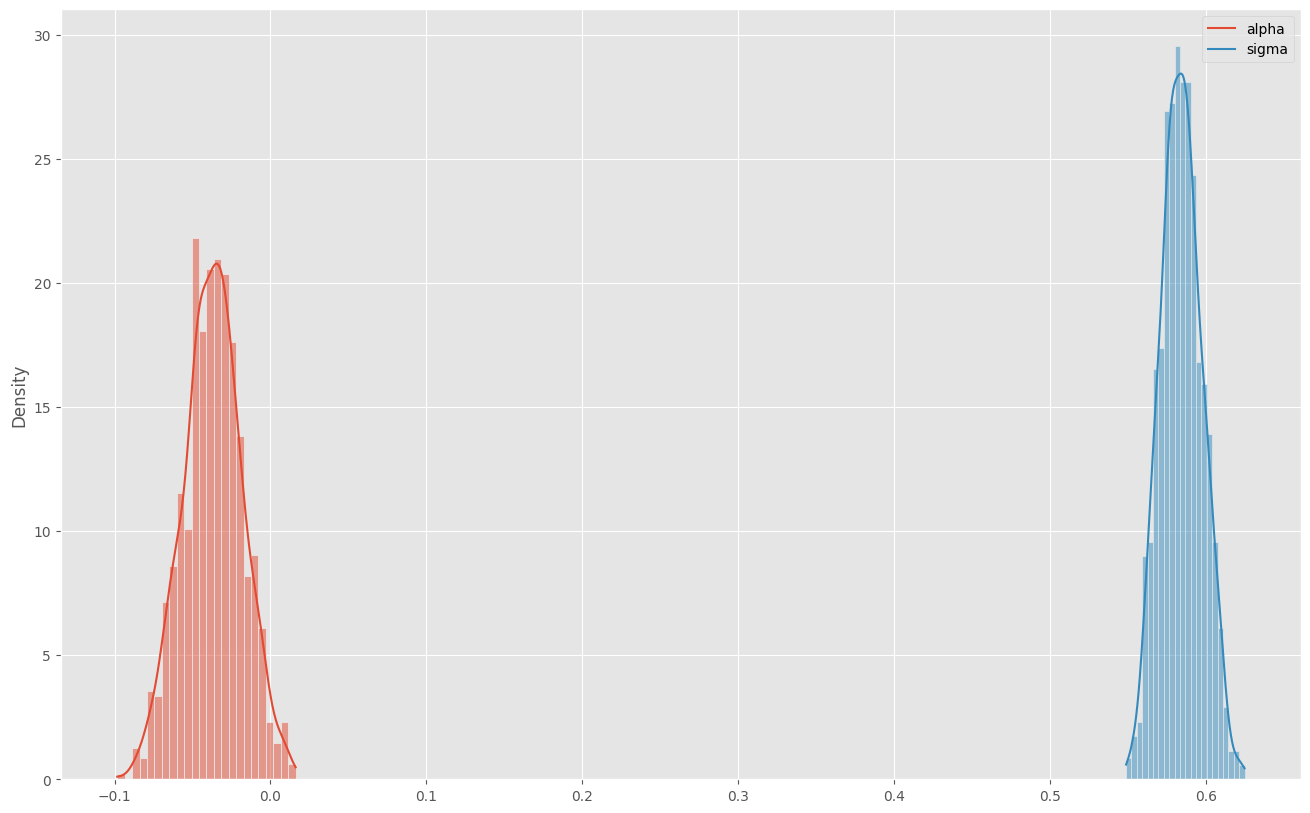

In [27]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.histplot(posterior_samples["alpha"], kde=True, stat="density")
sns.histplot(posterior_samples["sigma"], kde=True, stat="density")
plt.legend(["alpha", "sigma"])
plt.show()

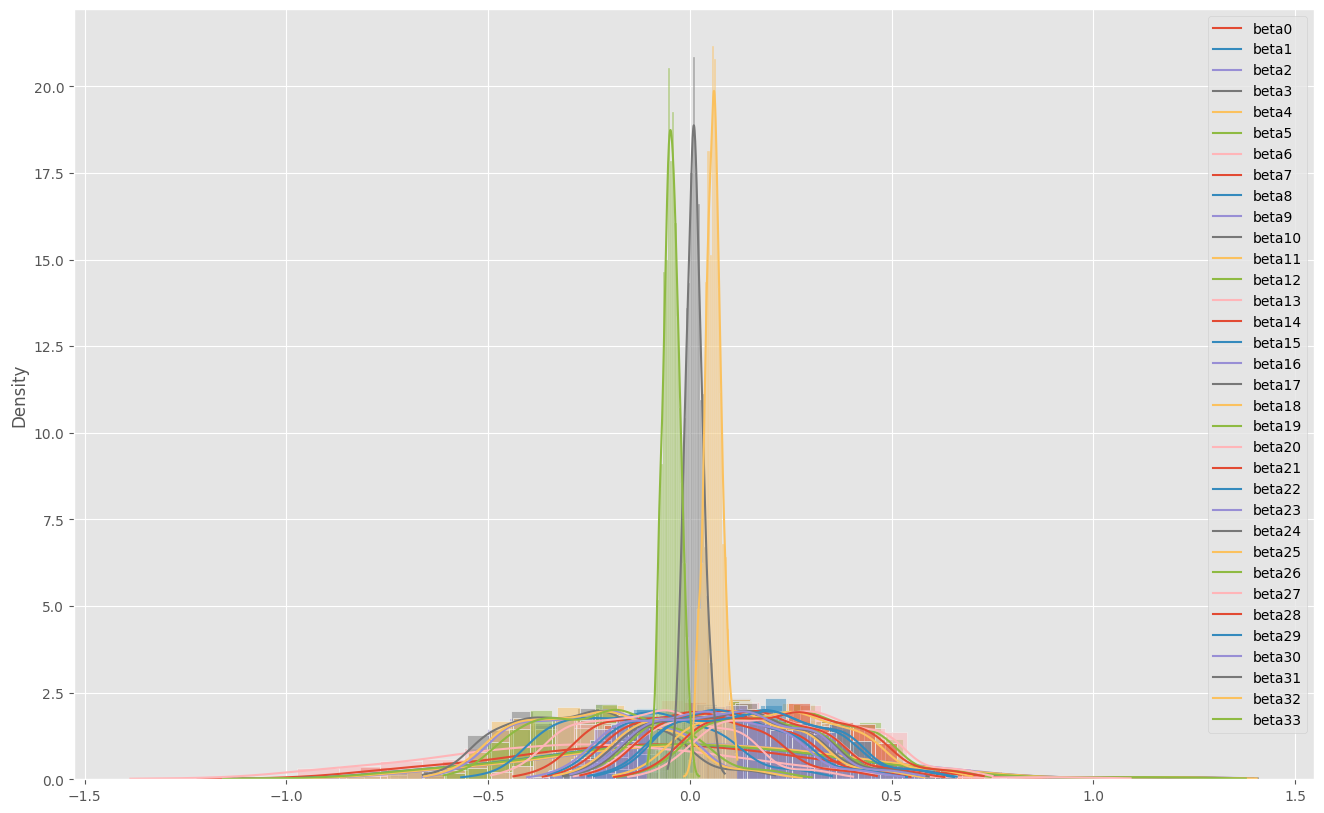

In [28]:
for i in range(X.shape[1]):
    sns.histplot(posterior_samples["beta"][:,i], kde=True, stat="density")
plt.legend(["beta%d" % i for i in range(X.shape[1])])
plt.show()

Now, lets extract the posterior samples from NumPyro and make predictions for the test set

In [29]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].T + np.dot(X_test, posterior_samples["beta"].T), axis=1)

In [30]:
# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.794
MAE: 19.724
RMSE: 26.549
R2: 0.627


The results are indeed the same ;)

Hopefully this Notebook gave you some feeling of the differences between Pyro and NumPyro. Again, notice that this Notebook is not intended to argue in favor of numpyro. Just think of all the advantages Pyro has in using the entire torch library (e.g. automatic differentiation, linear algebra operations, deep learning framework, etc.) 

The claim here is that, in practice, being able to use Pyro and NumPyro interchangibly will be a very useful skill for solving real-world problems.